In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifierCV
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF


In [3]:
df = pd.read_csv('music_features.csv')
df

,filename,tempo,beats,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00081.au,103.359375,50,0.380260,0.248262,2116.942959,1956.611056,4196.107960,0.127272,-26.929785,...,14.336612,-13.821769,7.562789,-6.181372,0.330165,-6.829571,0.965922,-7.570825,2.918987,blues
1,blues.00022.au,95.703125,44,0.306451,0.113475,1156.070496,1497.668176,2170.053545,0.058613,-233.860772,...,-2.250578,3.959198,5.322555,0.812028,-1.107202,-4.556555,-2.436490,3.316913,-0.608485,blues
2,blues.00031.au,151.999081,75,0.253487,0.151571,1331.073970,1973.643437,2900.174130,0.042967,-221.802549,...,-13.037723,-12.652228,-1.821905,-7.260097,-6.660252,-14.682694,-11.719264,-11.025216,-13.387260,blues
3,blues.00012.au,184.570312,91,0.269320,0.119072,1361.045467,1567.804596,2739.625101,0.069124,-207.208080,...,-0.613248,0.384877,2.605128,-5.188924,-9.527455,-9.244394,-2.848274,-1.418707,-5.932607,blues
4,blues.00056.au,161.499023,74,0.391059,0.137728,1811.076084,2052.332563,3927.809582,0.075480,-145.434568,...,7.457218,-10.470444,-2.360483,-6.783623,2.671134,-4.760879,-0.949005,0.024832,-2.005315,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,rock.00017.au,123.046875,59,0.418812,0.166056,2312.030070,2060.825761,4528.197619,0.140588,-41.402023,...,11.303100,-14.155566,2.824157,-9.477822,3.331261,-8.200088,3.693091,-3.673562,-0.163201,rock
996,rock.00081.au,117.453835,56,0.335774,0.093676,2553.856706,2219.090892,5123.752351,0.136173,-121.410791,...,9.149520,-10.112054,4.211237,-9.349345,1.609701,-10.553566,1.066489,-1.654875,7.544224,rock
997,rock.00004.au,103.359375,45,0.372834,0.208743,1345.850763,1841.748033,2939.265560,0.041099,-127.946876,...,11.043714,-8.385375,2.111019,-6.338260,0.997383,-5.325869,-0.842192,-4.665996,-4.787677,rock
998,rock.00006.au,112.347147,45,0.344472,0.180163,1675.475369,1653.422860,3253.563659,0.087294,-98.356322,...,2.945863,-12.509212,0.091337,-0.774780,-5.700102,-8.630916,-1.903803,-2.196753,-3.395148,rock


In [4]:
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])
label_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
print("Label mapping:", label_mapping)

Label mapping: {np.int64(0): 'blues', np.int64(1): 'classical', np.int64(2): 'country', np.int64(3): 'disco', np.int64(4): 'hiphop', np.int64(5): 'jazz', np.int64(6): 'metal', np.int64(7): 'pop', np.int64(8): 'reggae', np.int64(9): 'rock'}


In [5]:
features_to_standardize = [
    'tempo', 'chroma_stft', 'rmse', 'spectral_centroid', 
    'spectral_bandwidth', 'rolloff', 'zero_crossing_rate'
] + [f'mfcc{i}' for i in range(1, 21)]

for feature in features_to_standardize:
    df[feature] = (df[feature] - df[feature].mean()) / df[feature].std()

1. Correlation matrix

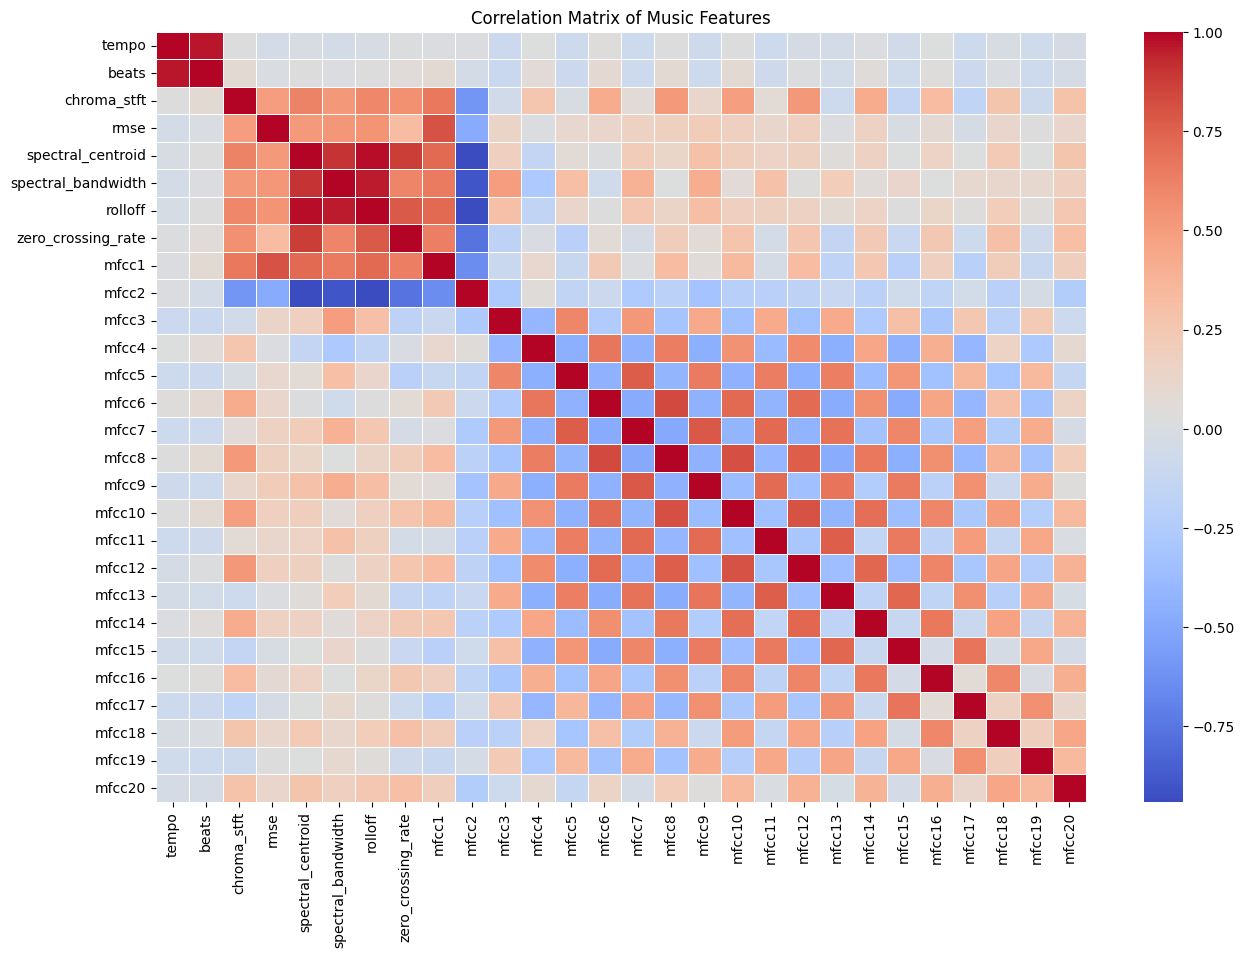

In [6]:
data_for_corr = df.drop(columns=['filename', 'label', 'label_encoded'])

corr_matrix = data_for_corr.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Music Features')
plt.show()

2. VIF calculation

In [7]:
df_vif = df.drop(columns=['filename', 'label', 'label_encoded'])
# print(df_vif.dtypes)

In [8]:
vals = [VIF(df_vif, i)
for i in range(0, df_vif.shape[1])]
vif = pd.DataFrame({'vif':vals},
index=df_vif.columns)
vif

,vif
tempo,1.108793
beats,1.058156
chroma_stft,3.442080
rmse,5.522599
spectral_centroid,215.835462
spectral_bandwidth,63.735429
rolloff,144.484544
zero_crossing_rate,25.864047
mfcc1,13.093881
mfcc2,19.416817


3. Previously Used models (Logistic Regression)

Without 'beats'

c:\Users\jonah\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Results on Test Set
Genre: blues
  Precision: 0.8000
  Recall: 0.6000
  F-score: 0.6857
  Support: 20
Genre: classical
  Precision: 0.9000
  Recall: 0.9000
  F-score: 0.9000
  Support: 20
Genre: country
  Precision: 0.5882
  Recall: 0.5000
  F-score: 0.5405
  Support: 20
Genre: disco
  Precision: 0.5455
  Recall: 0.6000
  F-score: 0.5714
  Support: 20
Genre: hiphop
  Precision: 0.6087
  Recall: 0.7000
  F-score: 0.6512
  Support: 20
Genre: jazz
  Precision: 0.6667
  Recall: 0.7000
  F-score: 0.6829
  Support: 20
Genre: metal
  Precision: 0.7917
  Recall: 0.9500
  F-score: 0.8636
  Support: 20
Genre: pop
  Precision: 0.7895
  Recall: 0.7500
  F-score: 0.7692
  Support: 20
Genre: reggae
  Precision: 0.5882
  Recall: 0.5000
  F-score: 0.5405
  Support: 20
Genre: rock
  Precision: 0.5455
  Recall: 0.6000
  F-score: 0.5714
  Support: 20


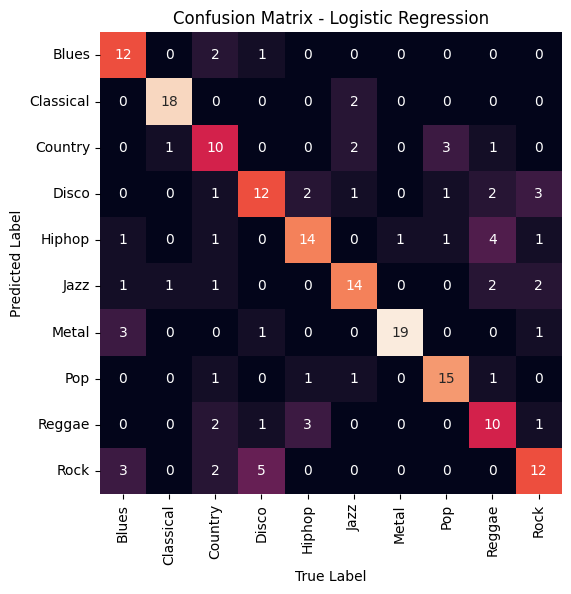

In [9]:
X = df[['tempo', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff'] + 
       [f'mfcc{i}' for i in range(1, 21)]]
y = df['label_encoded']

X_train, X_test, y_train, y_test_logistic = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

lm = LogisticRegression(class_weight='balanced', multi_class='multinomial', max_iter=1000)
lm.fit(X_train, y_train)

y_pred_logistic = lm.predict(X_test)

print("Logistic Regression Results on Test Set")
p, r, f, s = precision_recall_fscore_support(y_test_logistic, y_pred_logistic, labels=np.unique(y))
for label, genre in label_mapping.items():
    print(f"Genre: {genre}")
    print(f"  Precision: {p[label]:.4f}")
    print(f"  Recall: {r[label]:.4f}")
    print(f"  F-score: {f[label]:.4f}")
    print(f"  Support: {s[label]}")

target_names = ['Blues', 'Classical', 'Country', 'Disco', 'Hiphop', 'Jazz', 
                'Metal', 'Pop', 'Reggae', 'Rock']

mat_logistic = confusion_matrix(y_test_logistic, y_pred_logistic)

plt.figure(figsize=(8, 6))
sns.heatmap(mat_logistic.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

With 'beats'

c:\Users\jonah\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Results on Test Set
Genre: blues
  Precision: 0.8000
  Recall: 0.6000
  F-score: 0.6857
  Support: 20
Genre: classical
  Precision: 0.9000
  Recall: 0.9000
  F-score: 0.9000
  Support: 20
Genre: country
  Precision: 0.5556
  Recall: 0.5000
  F-score: 0.5263
  Support: 20
Genre: disco
  Precision: 0.5714
  Recall: 0.6000
  F-score: 0.5854
  Support: 20
Genre: hiphop
  Precision: 0.6087
  Recall: 0.7000
  F-score: 0.6512
  Support: 20
Genre: jazz
  Precision: 0.6667
  Recall: 0.7000
  F-score: 0.6829
  Support: 20
Genre: metal
  Precision: 0.7917
  Recall: 0.9500
  F-score: 0.8636
  Support: 20
Genre: pop
  Precision: 0.7895
  Recall: 0.7500
  F-score: 0.7692
  Support: 20
Genre: reggae
  Precision: 0.5882
  Recall: 0.5000
  F-score: 0.5405
  Support: 20
Genre: rock
  Precision: 0.5455
  Recall: 0.6000
  F-score: 0.5714
  Support: 20


c:\Users\jonah\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


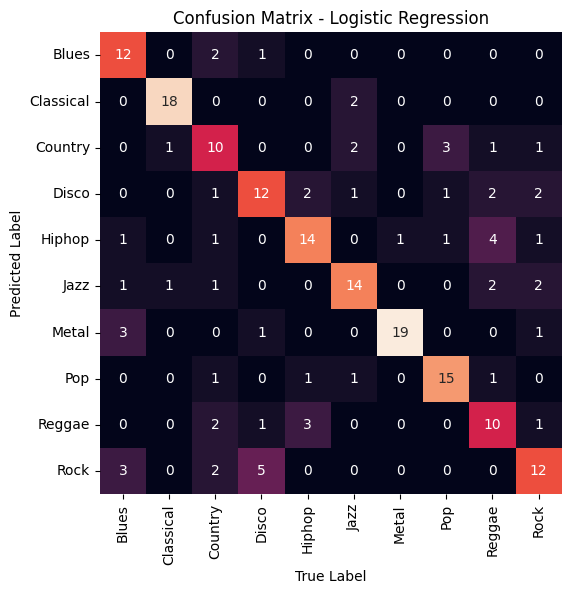

In [10]:
X = df[['tempo', 'beats', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff'] + 
       [f'mfcc{i}' for i in range(1, 21)]]
y = df['label_encoded']

X_train, X_test, y_train, y_test_logistic = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

lm = LogisticRegression(class_weight='balanced', multi_class='multinomial', max_iter=1000)
lm.fit(X_train, y_train)

y_pred_logistic = lm.predict(X_test)

print("Logistic Regression Results on Test Set")
p, r, f, s = precision_recall_fscore_support(y_test_logistic, y_pred_logistic, labels=np.unique(y))
for label, genre in label_mapping.items():
    print(f"Genre: {genre}")
    print(f"  Precision: {p[label]:.4f}")
    print(f"  Recall: {r[label]:.4f}")
    print(f"  F-score: {f[label]:.4f}")
    print(f"  Support: {s[label]}")

target_names = ['Blues', 'Classical', 'Country', 'Disco', 'Hiphop', 'Jazz', 
                'Metal', 'Pop', 'Reggae', 'Rock']

mat_logistic = confusion_matrix(y_test_logistic, y_pred_logistic)

plt.figure(figsize=(8, 6))
sns.heatmap(mat_logistic.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

Multinomial

              precision    recall  f1-score   support

       blues       0.55      0.55      0.55        20
   classical       0.89      0.85      0.87        20
     country       0.48      0.55      0.51        20
       disco       0.61      0.70      0.65        20
      hiphop       0.38      0.40      0.39        20
        jazz       0.67      0.60      0.63        20
       metal       0.93      0.65      0.76        20
         pop       0.79      0.75      0.77        20
      reggae       0.33      0.35      0.34        20
        rock       0.59      0.65      0.62        20

    accuracy                           0.60       200
   macro avg       0.62      0.60      0.61       200
weighted avg       0.62      0.60      0.61       200



c:\Users\jonah\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\jonah\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\jonah\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\jonah\AppData\Local\Programs\Python\P

              precision    recall  f1-score   support

       blues       0.46      0.55      0.50        20
   classical       0.89      0.80      0.84        20
     country       0.38      0.40      0.39        20
       disco       0.45      0.50      0.48        20
      hiphop       0.69      0.55      0.61        20
        jazz       0.70      0.70      0.70        20
       metal       0.75      0.75      0.75        20
         pop       0.74      0.85      0.79        20
      reggae       0.53      0.45      0.49        20
        rock       0.42      0.40      0.41        20

    accuracy                           0.59       200
   macro avg       0.60      0.59      0.60       200
weighted avg       0.60      0.59      0.60       200

              precision    recall  f1-score   support

       blues       0.43      0.45      0.44        20
   classical       0.86      0.95      0.90        20
     country       0.59      0.50      0.54        20
       disco       0.58 

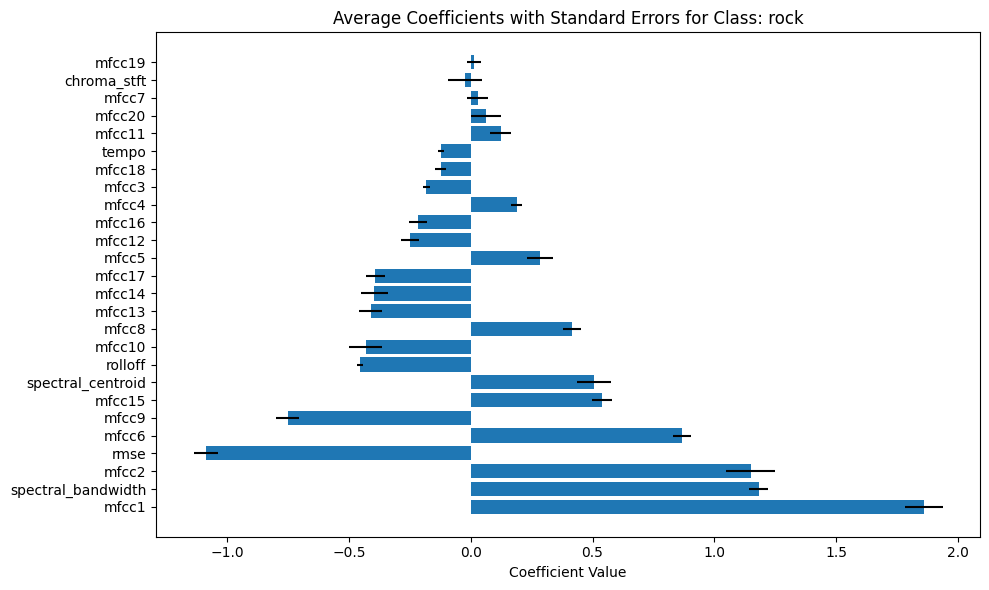

In [11]:
X = df[['tempo', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff'] + 
       [f'mfcc{i}' for i in range(1, 21)]]
y = df['label_encoded']

lm = LogisticRegression(class_weight='balanced', multi_class='multinomial', max_iter=1000)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
coefficients = []

for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    lm.fit(X_train, y_train)
    
    coefficients.append(lm.coef_)
    
    y_pred = lm.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=label_mapping.values()))


coefficients = np.array(coefficients)
avg_coefficients = np.mean(coefficients, axis=0)
std_error_coefficients = np.std(coefficients, axis=0) / np.sqrt(cv.get_n_splits())

coef_data = []
for class_idx, class_name in label_mapping.items():
    for feature_idx, feature_name in enumerate(X.columns):
        coef_data.append({
            'Class': class_name,
            'Feature': feature_name,
            'Average Coefficient': avg_coefficients[class_idx, feature_idx],
            'Standard Error': std_error_coefficients[class_idx, feature_idx]
        })

coef_df = pd.DataFrame(coef_data)
print(coef_df)

class_averages = coef_df.groupby('Class').agg(
    Average_Coefficient=('Average Coefficient', 'mean'),
    Average_Standard_Error=('Standard Error', 'mean')
).reset_index()
print(class_averages)

class_name_to_visualize = "rock"  # Change to any class you want to visualize
class_df = coef_df[coef_df['Class'] == class_name_to_visualize].sort_values(
    by='Average Coefficient', key=abs, ascending=False
)

plt.figure(figsize=(10, 6))
plt.barh(class_df['Feature'], class_df['Average Coefficient'], xerr=class_df['Standard Error'])
plt.xlabel('Coefficient Value')
plt.title(f'Average Coefficients with Standard Errors for Class: {class_name_to_visualize}')
plt.tight_layout()
plt.show()

N-best

In [12]:
lm_full = LogisticRegression(class_weight='balanced', multi_class='multinomial', max_iter=1000)
lm_full.fit(X, y)

coef_magnitudes = np.abs(lm_full.coef_).mean(axis=0)
top_features = np.argsort(coef_magnitudes)[-10:]
top_features_names = X.columns[top_features]

X_top = X[top_features_names]
X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42, stratify=y)

lm_top = LogisticRegression(class_weight='balanced', multi_class='multinomial', max_iter=1000)
lm_top.fit(X_train, y_train)

y_pred = lm_top.predict(X_test)
print("Logistic Model with Top-N Variables")
print(classification_report(y_test, y_pred, target_names=label_mapping.values()))
print("Top Features:", top_features_names)

Logistic Model with Top-N Variables
              precision    recall  f1-score   support

       blues       0.67      0.60      0.63        20
   classical       0.81      0.85      0.83        20
     country       0.53      0.40      0.46        20
       disco       0.39      0.60      0.47        20
      hiphop       0.57      0.60      0.59        20
        jazz       0.70      0.70      0.70        20
       metal       0.76      0.80      0.78        20
         pop       0.68      0.75      0.71        20
      reggae       0.58      0.55      0.56        20
        rock       0.50      0.30      0.38        20

    accuracy                           0.61       200
   macro avg       0.62      0.61      0.61       200
weighted avg       0.62      0.61      0.61       200

Top Features: Index(['mfcc6', 'mfcc17', 'mfcc11', 'spectral_bandwidth', 'mfcc9', 'mfcc4',
       'rmse', 'mfcc2', 'mfcc1', 'chroma_stft'],
      dtype='object')


c:\Users\jonah\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\jonah\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


VIF < 5

In [13]:
X_vif = X.copy()
vif_data = pd.DataFrame({
    'Feature': X_vif.columns,
    'VIF': [VIF(X_vif.values, i) for i in range(X_vif.shape[1])]
})

low_vif_features = vif_data[vif_data['VIF'] < 5]['Feature']
X_low_vif = X[low_vif_features]

X_train, X_test, y_train, y_test = train_test_split(X_low_vif, y, test_size=0.2, random_state=42, stratify=y)

lm_vif = LogisticRegression(class_weight='balanced', multi_class='multinomial', max_iter=1000)
lm_vif.fit(X_train, y_train)

y_pred = lm_vif.predict(X_test)
print("Logistic Model with Low-VIF Variables")
print(classification_report(y_test, y_pred, target_names=label_mapping.values()))
print("Low VIF Features:", low_vif_features.tolist())

Logistic Model with Low-VIF Variables
              precision    recall  f1-score   support

       blues       0.68      0.65      0.67        20
   classical       0.74      0.85      0.79        20
     country       0.61      0.55      0.58        20
       disco       0.59      0.65      0.62        20
      hiphop       0.50      0.55      0.52        20
        jazz       0.67      0.60      0.63        20
       metal       0.83      0.95      0.88        20
         pop       0.70      0.70      0.70        20
      reggae       0.42      0.40      0.41        20
        rock       0.38      0.30      0.33        20

    accuracy                           0.62       200
   macro avg       0.61      0.62      0.61       200
weighted avg       0.61      0.62      0.61       200

Low VIF Features: ['tempo', 'chroma_stft', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20']


c:\Users\jonah\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Backward Selection

In [14]:
def backward_selection(X, y, significance_level=1):
    X_with_const = sm.add_constant(X)
    
    model = sm.MNLogit(y, X_with_const).fit()
    
    while True:
        pvalues = model.pvalues.iloc[1:]
        max_pvalue = pvalues.max().max()
        
        if max_pvalue > significance_level:
            excluded_feature = pvalues.max(axis=1).idxmax()
            X_with_const = X_with_const.drop(columns=[excluded_feature]) 
            model = sm.MNLogit(y, X_with_const).fit()
        else:
            break

    return model, X_with_const.columns

model, selected_features = backward_selection(X, y)
print("Selected Features from Backward Selection:", selected_features)

X_selected = X[selected_features.drop("const")]
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

log_reg = sm.MNLogit(y_train, sm.add_constant(X_train)).fit()

y_pred_prob = log_reg.predict(sm.add_constant(X_test))
y_pred_class = np.argmax(y_pred_prob.values, axis=1)

unique_labels = sorted(np.unique(y))
target_names = [label_mapping[label] for label in unique_labels]

print("Backward Selection Classification Metrics")
print(classification_report(y_test, y_pred_class, target_names=target_names, labels=unique_labels))

Optimization terminated successfully.
         Current function value: 0.804390
         Iterations 11
Selected Features from Backward Selection: Index(['const', 'tempo', 'chroma_stft', 'rmse', 'spectral_centroid',
       'spectral_bandwidth', 'rolloff', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4',
       'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11',
       'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18',
       'mfcc19', 'mfcc20'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.790487
         Iterations 11
Backward Selection Classification Metrics
              precision    recall  f1-score   support

       blues       0.70      0.70      0.70        20
   classical       0.90      0.90      0.90        20
     country       0.56      0.50      0.53        20
       disco       0.52      0.60      0.56        20
      hiphop       0.58      0.55      0.56        20
        jazz       0.67      0.70      0

PCA

In [15]:
pca = PCA(n_components=10)
lm_pca = LogisticRegression(class_weight='balanced', multi_class='multinomial', max_iter=1000)
pcr_pipeline = Pipeline([('pca', pca), ('logistic', lm_pca)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
pcr_pipeline.fit(X_train, y_train)

y_pred = pcr_pipeline.predict(X_test)
print("Logistic Model with Principal Components")
print(classification_report(y_test, y_pred, target_names=label_mapping.values()))

Logistic Model with Principal Components
              precision    recall  f1-score   support

       blues       0.53      0.50      0.51        20
   classical       0.89      0.85      0.87        20
     country       0.20      0.10      0.13        20
       disco       0.33      0.30      0.32        20
      hiphop       0.28      0.35      0.31        20
        jazz       0.52      0.60      0.56        20
       metal       0.73      0.80      0.76        20
         pop       0.55      0.80      0.65        20
      reggae       0.50      0.50      0.50        20
        rock       0.27      0.20      0.23        20

    accuracy                           0.50       200
   macro avg       0.48      0.50      0.48       200
weighted avg       0.48      0.50      0.48       200



c:\Users\jonah\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Ridge

Ridge Classifier Classification Metrics
              precision    recall  f1-score   support

       blues       0.63      0.60      0.62        20
   classical       0.82      0.90      0.86        20
     country       0.67      0.50      0.57        20
       disco       0.58      0.35      0.44        20
      hiphop       0.65      0.65      0.65        20
        jazz       0.64      0.70      0.67        20
       metal       0.50      0.90      0.64        20
         pop       0.52      0.80      0.63        20
      reggae       0.50      0.45      0.47        20
        rock       0.60      0.15      0.24        20

    accuracy                           0.60       200
   macro avg       0.61      0.60      0.58       200
weighted avg       0.61      0.60      0.58       200

Best Lambda (Ridge Classifier): 3.7275937203149416


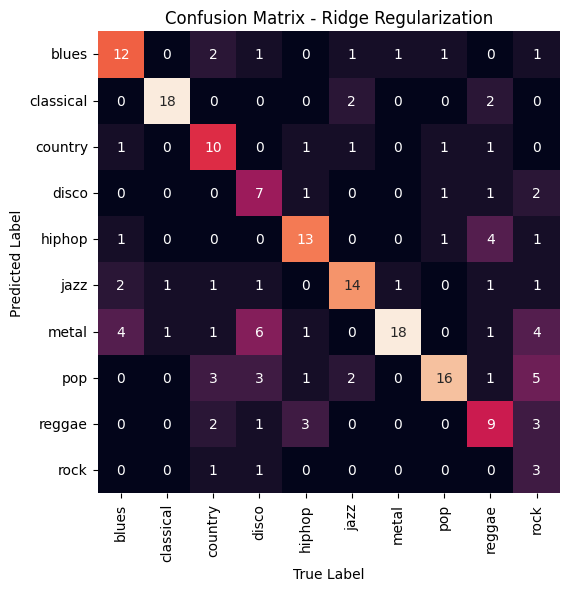

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

lambdas = 10**np.linspace(4, -2, 50)

ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', RidgeClassifierCV(alphas=lambdas, cv=5))
])

ridge_pipeline.fit(X_train, y_train)

y_pred_class = ridge_pipeline.predict(X_test)

unique_labels = sorted(np.unique(y_test))
target_names = [label_mapping[label] for label in unique_labels]

print("Ridge Classifier Classification Metrics")
print(classification_report(y_test, y_pred_class, target_names=target_names))

ridge_model = ridge_pipeline.named_steps['ridge']
best_lambda = ridge_model.alpha_
print("Best Lambda (Ridge Classifier):", best_lambda)

mat_logistic = confusion_matrix(y_test, y_pred_class)

plt.figure(figsize=(8, 6))
sns.heatmap(mat_logistic.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Confusion Matrix - Ridge Regularization')
plt.show()

Lasso

c:\Users\jonah\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best C: 1.2067926406393288
Best Alpha (1/C): 0.8286427728546844
Lasso Classifier Metrics
              precision    recall  f1-score   support

       blues       0.71      0.60      0.65        20
   classical       0.90      0.90      0.90        20
     country       0.50      0.50      0.50        20
       disco       0.60      0.60      0.60        20
      hiphop       0.57      0.60      0.59        20
        jazz       0.76      0.65      0.70        20
       metal       0.79      0.95      0.86        20
         pop       0.80      0.80      0.80        20
      reggae       0.55      0.55      0.55        20
        rock       0.57      0.60      0.59        20

    accuracy                           0.68       200
   macro avg       0.68      0.67      0.67       200
weighted avg       0.68      0.68      0.67       200

Non-zero Coefficients:
tempo: [ 0.01475643  0.28257833 -0.4065309  -0.00243892 -0.24560865 -0.06144752
  0.23984179  0.08991867  0.34232106 -0.11165176]

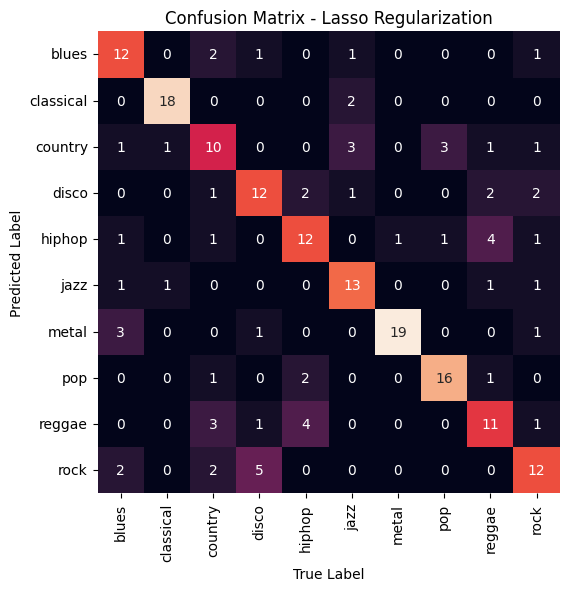

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

lasso_classifier_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        penalty='l1',
        solver='saga',
        max_iter=10000,
        class_weight='balanced',
        random_state=42,
        multi_class='multinomial',
        n_jobs=-1 
    ))
])

C_values = np.logspace(-4, 4, 50)
random_search = RandomizedSearchCV(
    estimator=lasso_classifier_pipeline,
    param_distributions={'logreg__C': C_values},
    n_iter=20,
    cv=5, 
    scoring='accuracy',
    random_state=42,
    n_jobs=-1 
)

random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_

best_C = random_search.best_params_['logreg__C']
best_alpha = 1 / best_C
print(f"Best C: {best_C}")
print(f"Best Alpha (1/C): {best_alpha}")

y_pred_class = best_model.predict(X_test)

unique_labels = sorted(np.unique(y_test))
target_names = [label_mapping[label] for label in unique_labels]

print("Lasso Classifier Metrics")
print(classification_report(y_test, y_pred_class, target_names=target_names))

coefficients = list(zip(best_model.named_steps['logreg'].coef_.T, X.columns))
non_zero_coefficients = [coef for coef in coefficients if np.any(coef[0] != 0)]

print("Non-zero Coefficients:")
for coef, name in non_zero_coefficients:
    print(f"{name}: {coef}")

mat_logistic = confusion_matrix(y_test, y_pred_class)

plt.figure(figsize=(8, 6))
sns.heatmap(mat_logistic.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Confusion Matrix - Lasso Regularization')
plt.show()

Elastic net

Best Alpha (1/C): 0.3593813663804626
Best L1 Ratio: 1.0
Elastic Net Classification Metrics
              precision    recall  f1-score   support

       blues       0.72      0.65      0.68        20
   classical       0.90      0.90      0.90        20
     country       0.53      0.50      0.51        20
       disco       0.57      0.65      0.60        20
      hiphop       0.57      0.60      0.59        20
        jazz       0.70      0.70      0.70        20
       metal       0.79      0.95      0.86        20
         pop       0.78      0.70      0.74        20
      reggae       0.56      0.50      0.53        20
        rock       0.63      0.60      0.62        20

    accuracy                           0.68       200
   macro avg       0.67      0.68      0.67       200
weighted avg       0.67      0.68      0.67       200

Non-zero Coefficients:
tempo: [ 0.00724098  0.32468022 -0.48763681 -0.06321783 -0.28427701 -0.08697538
  0.29392275  0.12825861  0.3290497  -0.1611081

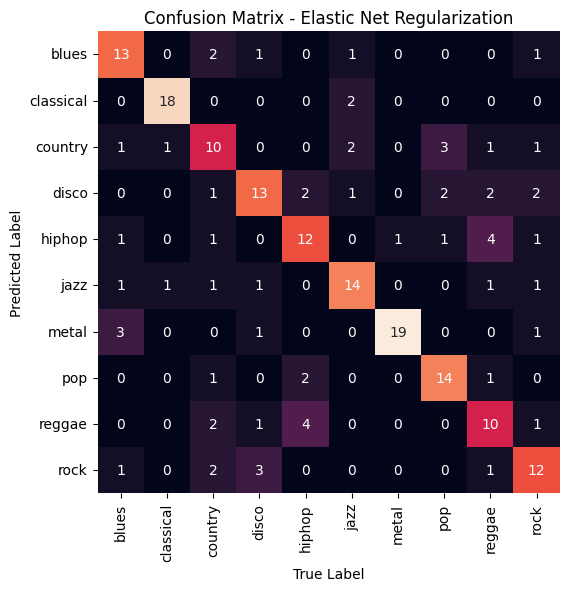

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

elastic_net_classifier = LogisticRegressionCV(
    penalty='elasticnet',
    solver='saga',
    max_iter=10000,
    class_weight='balanced',
    random_state=42,
    cv=5,
    l1_ratios=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

elastic_net_classifier.fit(X_train_scaled, y_train)

best_C = elastic_net_classifier.C_[0]
best_l1_ratio = elastic_net_classifier.l1_ratio_[0]

print(f"Best Alpha (1/C): {1/best_C}")
print(f"Best L1 Ratio: {best_l1_ratio}")

y_pred_class = elastic_net_classifier.predict(X_test_scaled)
unique_labels = sorted(np.unique(y_test))
target_names = [label_mapping[label] for label in unique_labels]

print("Elastic Net Classification Metrics")
print(classification_report(y_test, y_pred_class, target_names=target_names))

coefficients = list(zip(elastic_net_classifier.coef_.T, X.columns))
non_zero_coefficients = [coef for coef in coefficients if np.any(coef[0] != 0)]

print("Non-zero Coefficients:")
for coef, name in non_zero_coefficients:
    print(f"{name}: {coef}")

mat_logistic = confusion_matrix(y_test, y_pred_class)

plt.figure(figsize=(8, 6))
sns.heatmap(mat_logistic.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Confusion Matrix - Elastic Net Regularization')
plt.show()